In [139]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

import pathlib
import IPython.display as display
import os
import random

2.0.0-alpha0


### Load Images 

In [140]:
IMG_H, IMG_W = 160, 160
IMAGES_PATH = '../../image_gathering/imgs'
data_root = pathlib.Path(IMAGES_PATH)
print(data_root)

../../image_gathering/imgs


In [141]:
def show_example_images(ds, number=1):
    it = iter(ds)
    print('Example images:')
    for i in range(number):
        image, label = it.next()
        print(f'Class "{labels[0]}"')
        plt.imshow(image)
        plt.show()

def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [IMG_H, IMG_W])
  image /= 255.0  # normalize to [0,1] range
  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

def load_training_images(data_root):
    if not data_root.exists():
        raise
    # Images' paths
    all_image_paths = list(data_root.glob('*/*'))
    all_image_paths = [str(path) for path in all_image_paths]
    random.shuffle(all_image_paths)
    
    # Labels
    label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
    label_to_index = dict((name, index) for index,name in enumerate(label_names))
    all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

    ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))
    image_label_ds = ds.map(load_and_preprocess_from_path_label)
    
    # Extra info
    image_count = len(all_image_paths)
    print(f'Number of images: {image_count}')
    print(f'Label names: {label_names}')
    return image_label_ds, label_names, image_count


In [142]:
# Dataset of preprocessed images
ds, labels, image_count = load_training_images(data_root)

Number of images: 1056
Label names: ['ethernet']


Example images:
Class "ethernet"


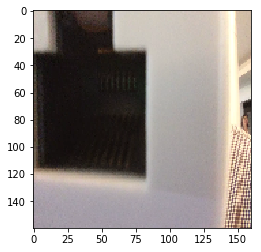

Class "ethernet"


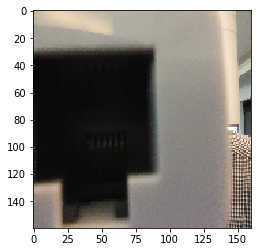

In [143]:
show_example_images(ds, 2)

In [144]:
def dataset_split(ds, image_count, test=0.05, dev=0.05, train=0.9):
    assert (test + dev + train == 1), 'test + dev + train should be equal to 1'
    nt, nd = int(test*image_count), int(dev*image_count)
    ntr = image_count - nt - nd
    ds_test = ds.take(nt) 
    ds_dev = ds.skip(nt).take(nd) 
    ds_train = ds.skip(nt + nd).take(ntr)
    return ds_test, ds_dev, ds_train

In [145]:
ds_test, ds_dev, ds_train = dataset_split(ds, image_count)
print(ds_test)
#show_example_images(ds_test)
#show_example_images(ds_dev)
#show_example_images(ds_train)

<TakeDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int32)>


### Transfer learning

In [155]:
IMG_SHAPE = (IMG_H, IMG_W, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [156]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [157]:
img = iter(ds_train.batch(1)).next()[0]
print(img.shape)
feature_batch = base_model(img)
print(feature_batch.shape)

(1, 160, 160, 3)
(1, 5, 5, 1280)


In [158]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(1, 1280)


In [159]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(1, 1)


In [160]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [161]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [162]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [168]:

BATCH_SIZE = 32
initial_epochs = 10
steps_per_epoch = BATCH_SIZE
validation_steps = 20
SHUFFLE_BUFFER_SIZE = 1000

train_batches = ds_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = ds_train.batch(BATCH_SIZE)
test_batches = ds_train.batch(BATCH_SIZE)

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 21s 1s/step - loss: 0.0141 - accuracy: 0.9906
initial loss: 0.01
initial accuracy: 0.99


In [169]:
print(validation_batches)

<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>


In [170]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
30/30 [==============================] - 71s 2s/step - loss: 0.2996 - accuracy: 0.9244 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 2/10
30/30 [==============================] - 66s 2s/step - loss: 0.0778 - accuracy: 0.9758 - val_loss: 3.9628e-04 - val_accuracy: 1.0000
Epoch 3/10
30/30 [==============================] - 69s 2s/step - loss: 0.0180 - accuracy: 0.9947 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
30/30 [==============================] - 69s 2s/step - loss: 0.0056 - accuracy: 0.9989 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
30/30 [==============================] - 68s 2s/step - loss: 0.0015 - accuracy: 0.9989 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
30/30 [==============================] - 70s 2s/step - loss: 3.6294e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
30/30 [==============================] - 69s 2s/step - loss: 6.6150e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accur

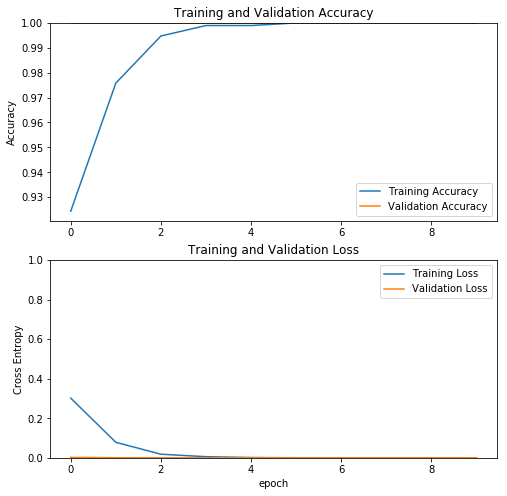

In [171]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [172]:
loss1,accuracy1 = model.evaluate(test_batches, steps = validation_steps)
print("final loss: {:.2f}".format(loss1))
print("final accuracy: {:.2f}".format(accuracy1))

20/20 [==============================] - 21s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000
final loss: 0.00
final accuracy: 1.00
